In [12]:
import pickle
import time
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn import metrics

import shap
import warnings

SEED = 123
shap.initjs()


In [2]:
MODEL_FOLDER = 'model/1708419562'

In [3]:
def get_models_and_pred(folder, labels):
    models = {}
    all_feature_names = None
    for l in labels:
        with open(f'{folder}/{l}_model.pkl', 'rb') as f:
            models[l] = pickle.load(f)
            
    with open(f'{folder}/all_feature_names.pkl', 'rb') as f:
        all_feature_names = pickle.load(f)
        
    pred = {}
    for l in ['train', 'test', 'val']:
        pred[l] = pd.read_csv(
            f'{folder}/{l}.csv', index_col=False).drop(
            columns=['Unnamed: 0'], errors='ignore')
    return models, pred, all_feature_names
    
labels = ['dummy', 'svc', 'lgbm', 'scaler']
models, pred, all_features = get_models_and_pred(MODEL_FOLDER, labels)

In [4]:
warnings.filterwarnings(action='ignore', category=UserWarning)

# use this condition to apply shap only on those samples where there is at least one communication registered
cond = lambda x: x[x[['n__fc__rw7', 'n__tc__rw7', 'n__fc__rw30', 'n__me__rw30']].sum(axis=1) > 0]

def shapify(predict_proba, representation_df, to_explain_df, perturbation_samples=100, feature_names=None):
    if not feature_names:
        feature_names = to_explain_df
        
    explainer = shap.KernelExplainer(predict_proba, representation_df, list(representation_df), 'logit')
    shap_values = explainer.shap_values(to_explain_df, nsamples=perturbation_samples, gc_collect=True)
    return shap_values, explainer
    


## Workflow Below Calculates SHAP values

Run the cells below to generate shap values as needed and save them into a file.

In [5]:
representation_df = shap.utils.sample(cond(pred['train']), 100, SEED)
to_explain_df = shap.utils.sample(cond(pred['test']), 500, SEED)

to_explain_df_raw = pd.DataFrame(
    models['scaler'].inverse_transform(to_explain_df[all_features]), 
    columns=list(to_explain_df[all_features])
)

shap_output = {}
shap_output['representation_df'] = representation_df
shap_output['to_explain_df'] = to_explain_df
shap_output['to_explain_df_raw'] = to_explain_df_raw


for model_name in ['svc', 'lgbm']:
    if model_name == 'svc':
        train_columns = models[model_name].feature_names_in_
    else:
        train_columns = models[model_name].feature_name_
    
    shap_values, explainer = shapify(
        models[model_name].predict_proba, 
        representation_df[train_columns], 
        to_explain_df[train_columns], 
        50)
    shap_output[model_name] = {}
    shap_output[model_name]['shap'] = shap_values
    shap_output[model_name]['explainer'] = explainer
    shap_output[model_name]['columns'] = train_columns

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
with open(f'{MODEL_FOLDER}/N{len(to_explain_df)}_{int(time.time())}.pkl', 'wb') as f:
    pickle.dump(shap_output, f)

# END

# Workflow Below Loads SHAP Values

Read SHAP values from a respective file for visualizing

In [5]:
with open(f'{MODEL_FOLDER}/N500_1708444356.pkl', 'rb') as f:
    shap_output = pickle.load(f)

In [6]:
model_name = 'svc'  # change to "lgbm" to review plots for LightGBM

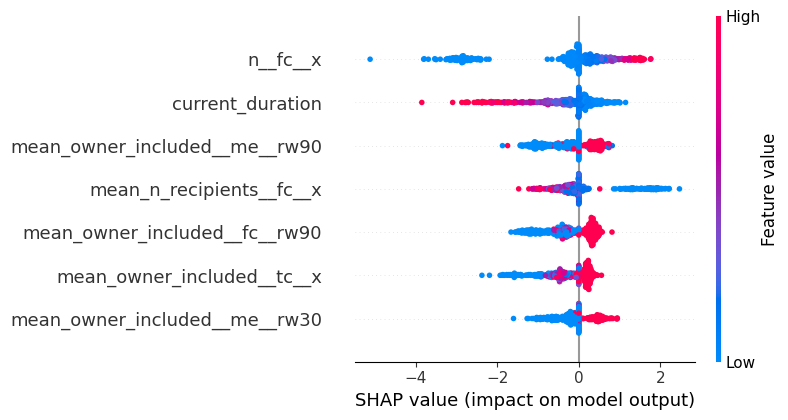

In [7]:
shap.summary_plot(
    shap_output[model_name]['shap'][1], 
    shap_output['to_explain_df_raw'][shap_output[model_name]['columns']], 
    max_display=7)

In [8]:
def force_plot(shap_output, model_name, index=None):
    if index:
        return shap.force_plot(
            shap_output[model_name]['explainer'].expected_value[1], 
            shap_output[model_name]['shap'][1][index, :], 
            shap_output['to_explain_df_raw'][shap_output[model_name]['columns']].iloc[index, :],
            link='logit'
        )
    else:
        return shap.force_plot(
            shap_output[model_name]['explainer'].expected_value[1], 
            shap_output[model_name]['shap'][1], 
            shap_output['to_explain_df_raw'][shap_output[model_name]['columns']],
            link='logit'
        )

force_plot(shap_output, model_name, 5)

# Financial Estimation

Assign a random amount (in USD) to each opportunity such that it follows $Norm(20000, 8000)$

In [9]:
unique_opps = pred['val'][['OpportunityId']].drop_duplicates()

np.random.seed(123)
amounts = np.random.normal(20000, 8000, len(unique_opps))
amounts = np.round(np.clip(amounts, 100, 100000))

amounts_df = pd.DataFrame({'OpportunityId': unique_opps.OpportunityId.values, 'Amount': amounts})
amounts_df

pred['val'] = pred['val'].merge(amounts_df, on='OpportunityId', how='inner')

## Estimate Losses for Use Case 1

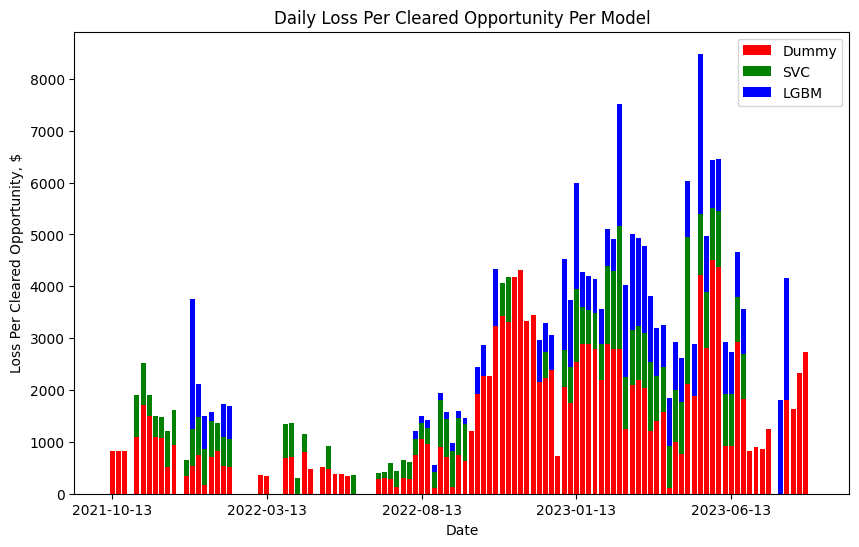

In [10]:


def financial_estimation(df, date: str):
    df = df[df.CreatedDate == date]
    opps_to_remove = df[df.target == 0]
    get_cost = lambda pred: (
        df[(df['target'] == 1) & (df[pred] == 0)].Amount.sum() / 
        len(df[(df['target'] == 0) & (df[pred] == 0)]))

    return get_cost('dummy_pred'), get_cost('svc_pred'), get_cost('lgbm_pred')

def harm_estimation(df):
    dates = df.sort_values('CreatedDate', ascending=True)['CreatedDate'].drop_duplicates().values
    estimates = [[], [], []]
    for date in dates:
        amounts = financial_estimation(df, date)
        for estimate, amount in zip(estimates, amounts):
            estimate.append(amount)
    # for estimate, model_name in zip(estimates[1:], ['dummy', 'svc', 'lgbm']):
    #     print(f"Daily MAE ({model_name}):\t${metrics.mean_absolute_error(estimates[0], estimate):.3f}")
    data = np.zeros(len(dates))
    plt.figure(figsize=(10, 6))
    for e, label, color in zip(estimates, ['Dummy', 'SVC', 'LGBM'], ['r', 'g', 'b']):
        plt.bar(dates, e, bottom=data, label=label, color=color)
        data += e
    plt.legend()
    plt.xticks(dates[0::25])
    plt.xlabel('Date')
    plt.ylabel('Loss Per Cleared Opportunity, $')
    plt.title('Daily Loss Per Cleared Opportunity Per Model')

harm_estimation(pred['val'])

        

## Estimate Deviation (MAE) from Target in Use Case 2

In [11]:
def financial_estimation(df, date: str):
    df = df[df.CreatedDate == date]
    true_amount = (df.target * df.Amount).sum()
    dummy_amount = (df.dummy_pred * df.Amount).sum()
    svc_amount = (df.svc_pred * df.Amount).sum()
    lgbm_amount = (df.lgbm_pred * df.Amount).sum()
    return true_amount, dummy_amount, svc_amount, lgbm_amount


def get_financial_stats(df):
    dates = df.sort_values('CreatedDate', ascending=True)['CreatedDate'].drop_duplicates().values
    estimates = [[], [], [], []]
    for date in dates:
        amounts = financial_estimation(df, date)
        for estimate, amount in zip(estimates, amounts):
            estimate.append(amount)
    print(f"Average Target:\t\t${np.average(estimates[0]):.3f}")
    for estimate, model_name in zip(estimates[1:], ['dummy', 'svc', 'lgbm']):
        print(f"Daily MAE ({model_name}):\t${metrics.mean_absolute_error(estimates[0], estimate):.3f}")
        
        

get_financial_stats(pred['val'])

Average Target:		$42549.553
Daily MAE (dummy):	$63007.789
Daily MAE (svc):	$130838.298
Daily MAE (lgbm):	$304305.053
